# Stress Prediction Model

Este notebook implementa un pipeline para *Harmonia*, enfocado en generar un dataset sintético basado en hábitos de bienestar y entrenar modelos de Machine Learning para predecir el nivel de estrés del usuario.

Incluye:
- Generación de datos sintéticos (sueño, pasos, estado de ánimo, consistencia, historial).
- Cálculo del `total_score` como indicador general de bienestar.
- Clasificación del nivel de estrés (`low`, `medium`, `high`, `critical`).
- Entrenamiento de modelos Random Forest para clasificación y regresión.
- Evaluación del rendimiento, matriz de confusión e importancia de variables.
- Exportación del dataset generado, gráficos y modelos entrenados.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import joblib
import os

In [ ]:
# Crear carpeta de salida

OUTPUT_DIR = "harmonia_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Función para calcular score

def calculate_total_score(row):
    sleep_score = min(row['sleep_hours'] / 8, 1) * 30

    steps_score = 0
    if row['steps'] >= 10000:
        steps_score = 25
    elif row['steps'] >= 5000:
        steps_score = 20
    elif row['steps'] >= 3000:
        steps_score = 15
    elif row['steps'] >= 1000:
        steps_score = 10
    else:
        steps_score = 5

    mood_score = (row['mood_recent_avg'] / 5) * 25
    consistency_score = (row['consistency_pct'] / 100) * 20

    historical_weight = 0.2
    daily_weight = 0.8
    historical_score = row['historical_avg_score'] * historical_weight

    daily_total = (
        sleep_score * daily_weight +
        steps_score +
        mood_score +
        consistency_score
    )

    total = historical_score + daily_total
    return min(total, 100)


In [ ]:
# Generación de datos sintéticos

np.random.seed(42)
N = 25000

df = pd.DataFrame({
    "sleep_hours": np.random.normal(7, 1.5, N).clip(3, 10),
    "steps": np.random.normal(6000, 3000, N).clip(200, 20000),
    "mood_recent_avg": np.random.uniform(1, 5, N),
    "mood_entries_count": np.random.randint(3, 60, N),
    "consistency_pct": np.random.uniform(30, 100, N),
    "historical_avg_score": np.random.uniform(40, 90, N)
})

df["total_score"] = df.apply(calculate_total_score, axis=1)

# Añadimos ruido para simular datos reales
df["total_score"] = df["total_score"] + np.random.normal(0, 5, N)
df["total_score"] = df["total_score"].clip(0, 100)


In [ ]:
# Generar etiquetas de nivel de estrés

def score_to_stress(score):
    if score >= 75:
        return "low"
    elif score >= 50:
        return "medium"
    elif score >= 25:
        return "high"
    else:
        return "critical"

df["stress_level"] = df["total_score"].apply(score_to_stress)

In [ ]:
# Mostrar dataset generado

print("\n=== Dataset Generado ===")
display(df.head())


# Guardar el dataset completo generado

df.to_csv(f"{OUTPUT_DIR}/dataset_generated.csv", index=False)
print("\nDataset guardado en:", f"{OUTPUT_DIR}/dataset_generated.csv")



=== Dataset Generado ===


,sleep_hours,steps,mood_recent_avg,mood_entries_count,consistency_pct,historical_avg_score,total_score,stress_level
0,7.745071,6512.620586,1.011082,51,52.151683,54.604867,73.183130,medium
1,6.792604,6036.766292,2.530091,29,72.989864,55.728512,65.965552,medium
2,7.971533,4706.534801,4.656197,5,72.076571,65.506513,88.683070,low
3,9.284545,5992.420017,4.791020,8,48.152116,61.405421,81.843729,low
4,6.648770,7472.524876,1.214237,31,83.601482,44.286672,75.645674,low



Dataset guardado en: harmonia_models/dataset_generated.csv


In [ ]:
# Train/Test Split

FEATURES = [
    "sleep_hours", "steps", "mood_recent_avg", "mood_entries_count",
    "consistency_pct", "historical_avg_score"
]

X = df[FEATURES]
y_class = df["stress_level"]
y_reg = df["total_score"]

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

In [ ]:
# Entrenar modelos

clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
clf.fit(X_train, y_train_class)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       random_state=42)

In [ ]:
reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_train, y_train_reg)


RandomForestRegressor(n_estimators=300, random_state=42)

In [ ]:
# Métricas de Clasificación

y_pred_class = clf.predict(X_test)

print("\n=== Classification Metrics ===")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class))



=== Classification Metrics ===
Accuracy: 0.8566

Classification Report:
               precision    recall  f1-score   support

        high       0.50      0.05      0.09        21
         low       0.88      0.91      0.89      3202
      medium       0.81      0.78      0.79      1777

    accuracy                           0.86      5000
   macro avg       0.73      0.58      0.59      5000
weighted avg       0.85      0.86      0.85      5000



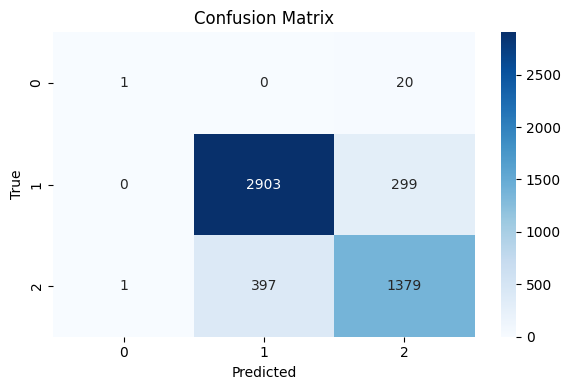

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

# Guardarla como archivo
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=300)

# Mostrar
plt.show()
plt.close()


In [ ]:
# Métricas de Regresión

y_pred_reg = reg.predict(X_test)

mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n=== Regression Metrics ===")
print("MAE:", mae)
print("RMSE:", np.sqrt(mse))
print("R²:", r2)


=== Regression Metrics ===
MAE: 4.114307915896801
RMSE: 5.172213055484063
R²: 0.7698444930657766


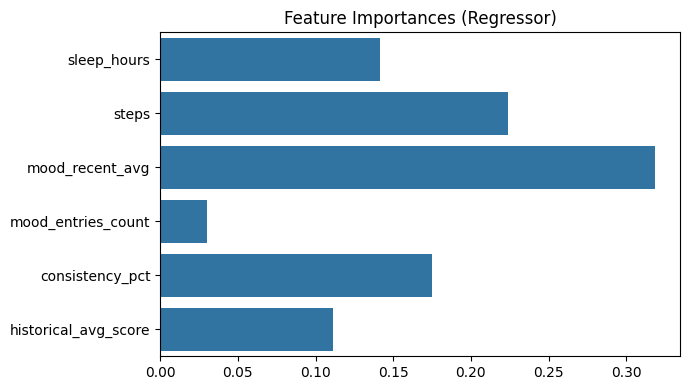

In [ ]:
# Importancia de características

importances = reg.feature_importances_
plt.figure(figsize=(7, 4))
sns.barplot(x=importances, y=FEATURES)
plt.title("Feature Importances (Regressor)")
plt.tight_layout()
# Guardarla como archivo
plt.savefig(f"{OUTPUT_DIR}/feature_importances.png", dpi=300)

# Mostrar
plt.show()
plt.close()

In [ ]:
# Guardar modelos

joblib.dump(clf, f"{OUTPUT_DIR}/rf_classifier_stress.pkl")
joblib.dump(reg, f"{OUTPUT_DIR}/rf_regressor_score.pkl")

print("\nModelos guardados en:", OUTPUT_DIR)


Modelos guardados en: harmonia_models
